# Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Captions 

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

In [ ]:
doc = doc.split('\n')[:-1]

In [ ]:
len(doc)

40460

In [ ]:
descriptions = {}
for lines in doc:
  image_id, text = lines.split('\t')
  image_id = image_id.split(".")[0]
  if descriptions.get(image_id) is None:
    descriptions[image_id] = []
  descriptions[image_id].append(text)

In [ ]:
descriptions["930748509_8ca5cf5c24"]

['A man in pets a dog on the chest at a park .',
 'A man petting a dog .',
 'A young man scratches the neck of a dog .',
 'A young man sits with a dog outside .',
 'a young man sitting and petting his dog']

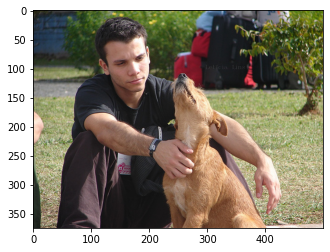

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.image as img
test_img = img.imread("/content/drive/My Drive/Colab Notebooks/Images/930748509_8ca5cf5c24"+".jpg")
plt.imshow(test_img)

In [ ]:
descriptions['930748509_8ca5cf5c24'][2]

'a young man scratches the neck of a dog'

# Pre-Processing the Datasets .

## Data Cleaning 


In [ ]:
import re
for k,sentences in descriptions.items():
  for i in range(0,len(sentences)):
    words = sentences[i]
    words = words.lower()
    words = words.split(" ")
    words = [word for word in words if word.isalpha()]
    words = ' '.join(words)
    words = re.sub('[^a-z]+', " ", words)
    sentences[i] = words

In [ ]:
descriptions['930748509_8ca5cf5c24']

['a man in pets a dog on the chest at a park',
 'a man petting a dog',
 'a young man scratches the neck of a dog',
 'a young man sits with a dog outside',
 'a young man sitting and petting his dog']

## Making the Vocabulary

In [ ]:
w = set()
for k,sentences in descriptions.items():
  for i in sentences:
    i = str(i).split(" ")
    w.update(i)

In [ ]:
len(w)

8369

In [ ]:
vocab = {}
for k,sentences in descriptions.items():
  for i in range(0,len(sentences)):
    words = sentences[i]
    words = words.split(" ")
    for i in range(0,len(words)):
      if words[i] not in vocab.keys():
        vocab[words[i]] = 0
      vocab[words[i]] += 1

In [ ]:
len(vocab)


8369

In [ ]:
vocab_final_freq = {}
vocab_final = []
for k,v in vocab.items():
  if v>=10:
    vocab_final_freq[k] = v
    vocab_final.append(k)


  


In [ ]:
print(len(vocab_final))
print(len(vocab_final_freq))

1939
1939


In [ ]:
import operator
sorted_vocab = sorted(vocab_final_freq.items(), key=operator.itemgetter(1))

In [ ]:
sorted_vocab[0]

('pizza', 10)

In [ ]:

len(vocab_final)

1939

## Plotting the Frequencies of the Vocab

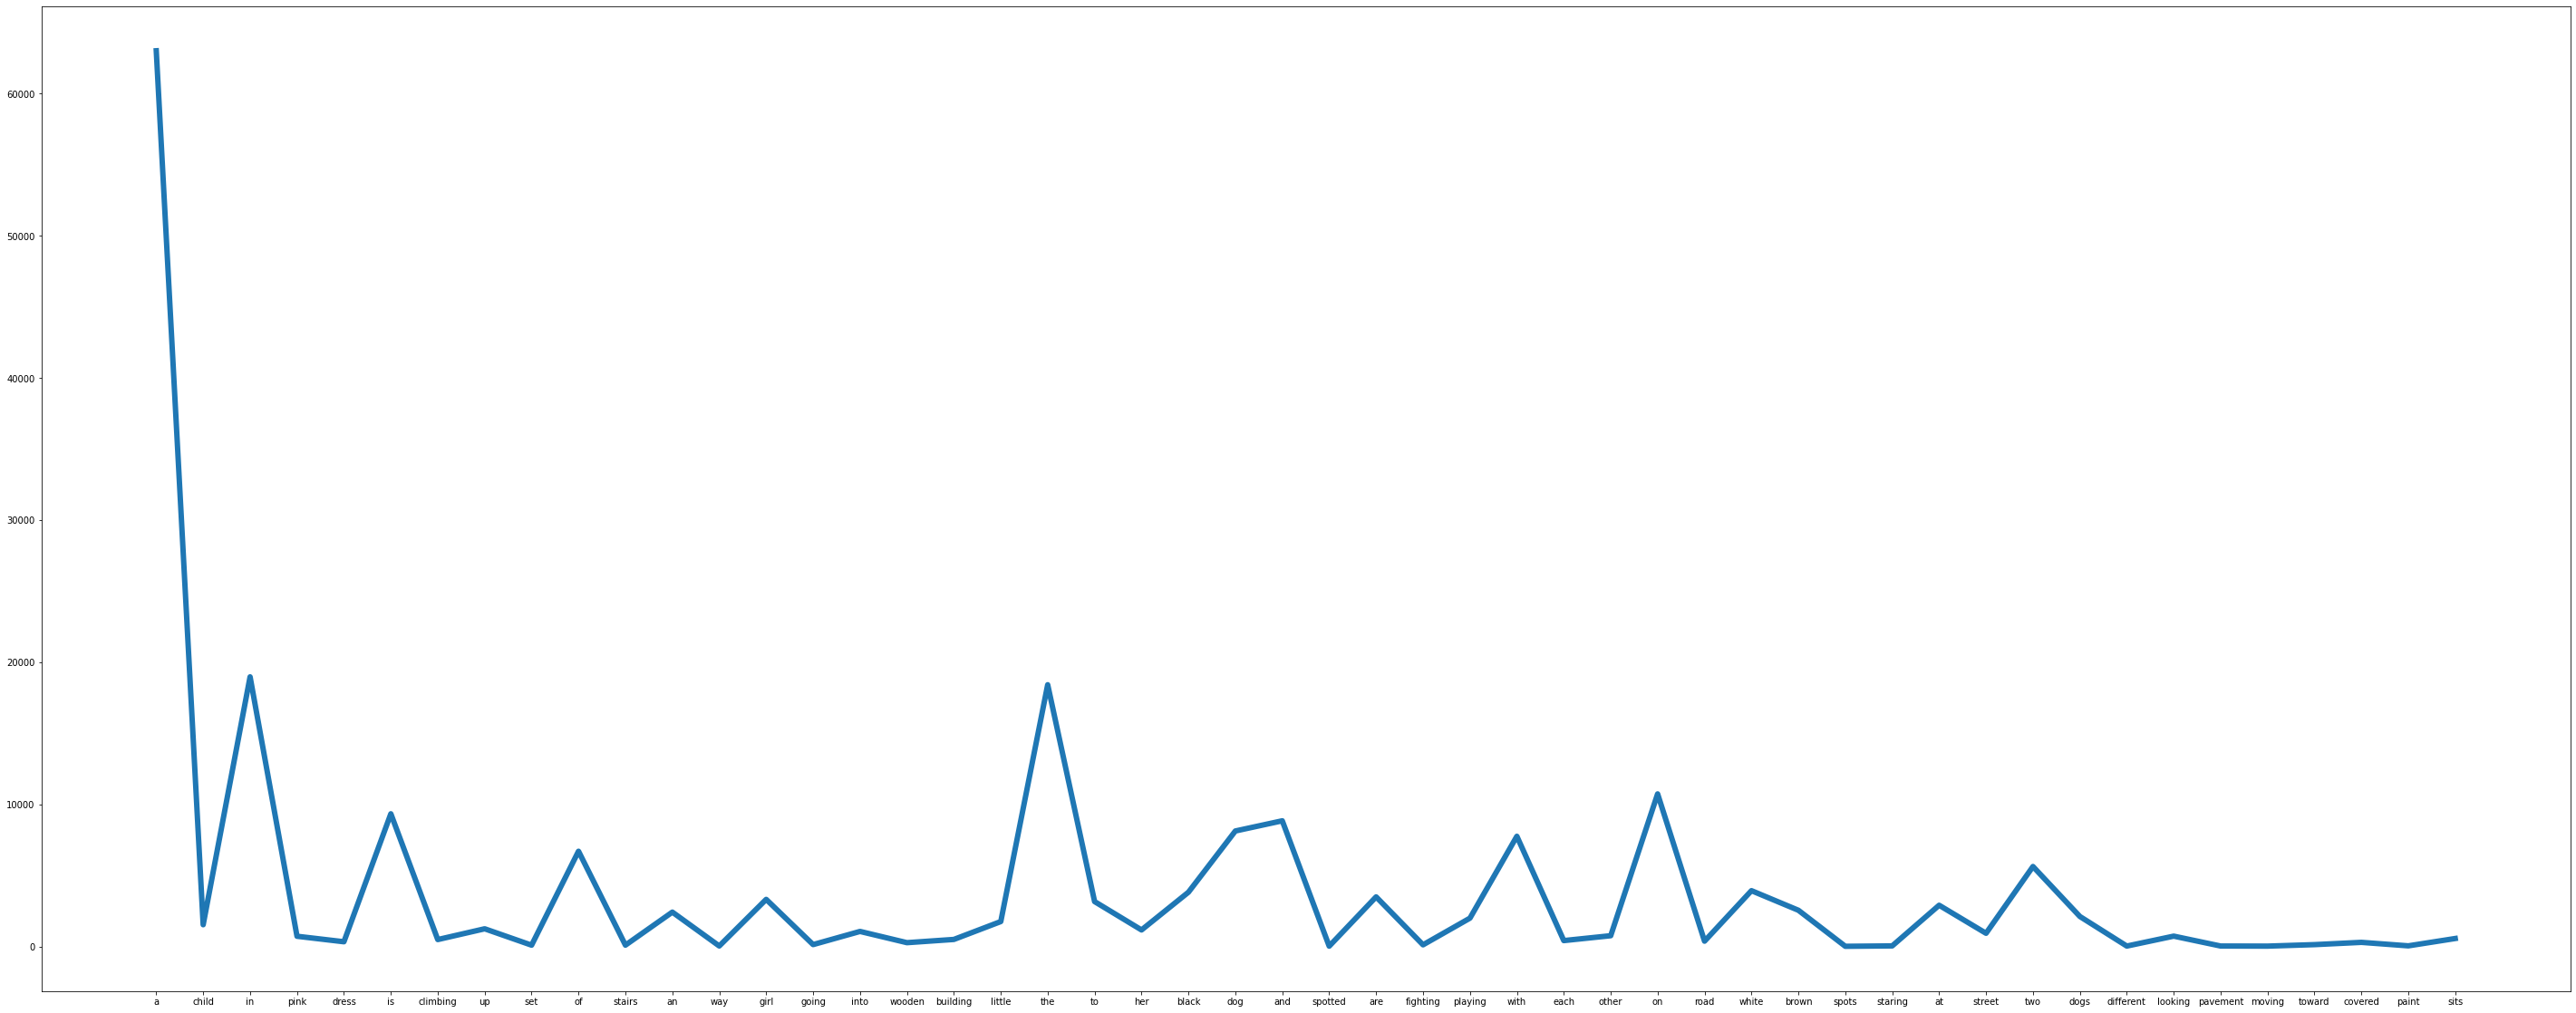

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
x = list(vocab_final_freq.keys())[0:50]
y = list(vocab_final_freq.values())[0:50]
plt.figure(figsize=(50,20))
matplotlib.rcParams.update({'font.size': 10})
plt.plot(x,y,linewidth=6)

In [ ]:
image_ids = []
for k in descriptions.keys():
  image_ids.append(k)

In [ ]:
np.array(image_ids).size

8092

# Loading the Train Set

In [ ]:
filename1 = "/content/drive/My Drive/Colab Notebooks/Flickr_TextData/Flickr_8k.trainImages.txt"
file1= open(filename1, 'r')
doc1 = file1.read()

In [ ]:
doc1 = doc1.split('\n')[:-1]

In [ ]:
np.array(doc1).shape

(6000,)

In [ ]:
train_set = []
i = 0
for k in doc1:
  k = k.split('.')[0]
  train_set.append(k)
  i = i+1
train_set[0:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
len(train_set)

6000

In [ ]:
train_des = {}
for ids in train_set:
  for des in descriptions[ids]:
    des = 'startseq ' + des + ' endseq'
    if ids not in train_des.keys():
      train_des[ids] = []
    train_des[ids].append(des)

In [ ]:
train_des['2513260012_03d33305cf']

['startseq a black dog is running after a white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through a low lying body of water endseq']

# Using the ResNet to Convert Images into Vectors

In [1]:
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, RepeatVector,TimeDistributed, Add
from tensorflow.keras.layers import add
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [2]:
model = ResNet50(weights='imagenet', input_shape=(224,224,3))
model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [3]:
new_model = Model(model.input, model.layers[-2].output)

In [4]:
def pre_process_img(img):
  img = load_img("/content/drive/My Drive/Colab Notebooks/Images/"+img+".jpg",target_size=(224,224))
  img = img_to_array(img)
  img = preprocess_input(img)
  return img



In [5]:
img = "930748509_8ca5cf5c24"
img1 = pre_process_img(img)
plt.imshow(img1)

FileNotFoundError: ignored

In [ ]:
def encode_img(img):
  img = pre_process_img(img)
  img = img.reshape(1,224,224,3)
  img_features = new_model.predict(img)
  img_features = img_features.reshape((-1,))
  return img_features

In [ ]:
img = "930748509_8ca5cf5c24"
img = encode_img(img)
img.shape

In [ ]:
train_img_vectors = {}
count = 0;
for k,v in train_des.items():
  img = encode_img(k)
  train_img_vectors[k] = img
  count = count + 1
  if(count%100==0):
    print("Printing step no. : ",count)
   

In [ ]:
train_img_vectors['2903617548_d3e38d7f88'].shape

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/encoded_train_matrices.pkl","wb") as f:
    pickle.dump(train_img_vectors,f)

In [ ]:
word_2_idx = {}
idx_2_word = {}
for i,words in enumerate(vocab_final):
  word_2_idx[words] = i+1
  idx_2_word[i+1] = words


In [ ]:
print(word_2_idx['art'])
print(idx_2_word[285])
print()

In [ ]:
len(word_2_idx)

In [ ]:
word_2_idx['startseq'] = 1940
idx_2_word[1940] = 'startseq'

word_2_idx['endseq'] = 1941
idx_2_word[1941] = 'endseq'

In [ ]:
word_2_idx['endseq']

In [ ]:
max_len = 0 
for key in train_des.keys():
    for cap in train_des[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)


# Preparing the Word Embedding 

In [ ]:
f = open("/content/drive/My Drive/Colab Notebooks/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [ ]:
embedding_index['boy']

array([-0.32345 ,  0.23332 , -0.20082 , -0.52848 ,  1.0926  ,  0.62445 ,
       -0.99859 ,  0.28085 ,  0.088326,  0.36919 ,  0.32199 ,  0.3499  ,
        0.067459,  0.24211 ,  0.92565 , -0.32581 , -0.99134 ,  0.80767 ,
       -0.22845 ,  0.40076 , -0.8577  ,  1.3836  ,  0.056439,  0.76561 ,
        0.3608  , -2.0692  , -0.46679 ,  0.12359 ,  0.35127 , -0.77092 ,
        2.2064  , -0.42605 , -0.24279 ,  0.3832  ,  0.6069  ,  0.62835 ,
        0.31825 , -0.8851  ,  0.38329 , -1.146   , -0.41949 ,  0.2606  ,
       -0.6568  , -0.11511 ,  1.0591  , -0.61148 ,  0.32152 , -1.3182  ,
        0.31744 ,  0.02527 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((len(word_2_idx)+1,emb_dim))
    for word,idx in word_2_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix[43]

array([ 0.50113 ,  0.41569 , -0.29695 ,  0.10243 ,  0.41572 ,  0.70124 ,
       -0.20413 , -0.95497 , -0.63545 , -0.086705,  0.32744 ,  0.29916 ,
       -0.068226,  0.21065 ,  0.052   ,  0.10911 ,  0.069841,  0.023721,
        0.076539, -1.2528  , -0.25439 , -0.053507,  1.0071  ,  0.71453 ,
        0.21825 , -0.49822 , -1.0179  , -0.34392 ,  0.17144 , -0.55879 ,
        4.0882  ,  0.17536 ,  0.1053  , -1.294   ,  0.70787 ,  0.18151 ,
       -0.13555 ,  0.32992 , -0.85925 ,  0.56715 , -0.28607 , -0.072084,
        0.39025 ,  0.77524 , -0.019722,  0.2923  ,  0.32779 ,  0.16057 ,
       -0.50284 ,  0.052809])

In [ ]:
embedding_size = 50
max_len = 36

# Model

In [ ]:
#Branch1 - for image features
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=1942,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
#Merging the branches
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(1942,activation='softmax')(decoder2)


In [ ]:
# Final Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 36, 50)       97100       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
image_vectors = pd.read_pickle( "/content/drive/My Drive/Colab Notebooks/encoded_train_matrices.pkl")

print(len(image_vectors))

6000


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Data Generator 

In [ ]:
def DataGenerator(train_descriptions,batch_size,encoding_train,word_to_idx):
    X1,X2,y=[],[],[]
    #x1- image features, x2=captions ,y = next word that should be predicted
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = keras.utils.to_categorical([yi],num_classes=1942)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
            if n==batch_size:
                yield ([np.array(X1),np.array(X2)],np.array(y))
                X1,X2,y = [],[],[]
                n = 0

# Training the Model

In [ ]:
import keras
epochs = 20
number_pics_per_bath = 3
steps = len(train_des)//number_pics_per_bath
for i in range(epochs):
    generator = DataGenerator(train_des,number_pics_per_bath,image_vectors,word_2_idx)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 31s 15ms/step - loss: 2.2667


In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Model Weights/final_Model.h5')

# Loading the Test Data 

In [ ]:
test_file = open('/content/drive/My Drive/Colab Notebooks/Flickr_TextData/Flickr_8k.testImages.txt')

In [ ]:
test_set=test_file.read()

In [ ]:
test_set=test_set.split("\n")[:-1]

In [ ]:
test_img=[]
for it in test_set:
  it=it.split(".")[0]
  test_img.append(it)

In [ ]:
test_img_vector={}
for i,item in enumerate(test_img):
  path="/content/drive/My Drive/Colab Notebooks/Images/"+item+".jpg"
  test_img_vector[item]=encode_img(item)
  if i%100==0:
    print("Encoding in progress in step %d "%i)

1/1 [==============================] - 0s 24ms/step
Encoding in progress in step 0 
1/1 [==============================] - 0s 22ms/step
Encoding in progress in step 100 
1/1 [==============================] - 0s 21ms/step
Encoding in progress in step 200 
1/1 [==============================] - 0s 22ms/step
Encoding in progress in step 300 
1/1 [==============================] - 0s 26ms/step
Encoding in progress in step 400 
1/1 [==============================] - 0s 21ms/step
Encoding in progress in step 500 
1/1 [==============================] - 0s 21ms/step
Encoding in progress in step 600 
1/1 [==============================] - 0s 22ms/step
Encoding in progress in step 700 
1/1 [==============================] - 0s 24ms/step
Encoding in progress in step 800 
1/1 [==============================] - 0s 22ms/step
Encoding in progress in step 900 
1/1 [==============================] - 0s 22ms/step


In [ ]:
import pickle
with open("/content/drive/My Drive/Colab Notebooks/encoded_test_matrices.pkl","wb") as d:
  pickle.dump(test_img_vector,d)

# Predicting the Captions 

In [ ]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence], maxlen=max_len,padding='post')
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_2_word[yhat]
        in_text += (' ' + word)
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
image_output_vectors = pd.read_pickle( "/content/drive/MyDrive/Colab Notebooks/encoded_test_matrices.pkl")

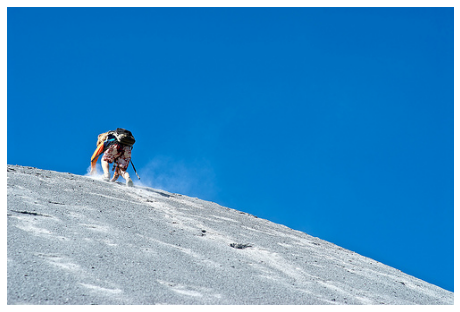

a man in a red jacket and black backpack is skiing down a hill


In [ ]:
idx=20
pic = list(image_output_vectors.keys())[idx]
image = image_output_vectors[pic].reshape((1,2048))
x=plt.imread("/content/drive/MyDrive/Colab Notebooks/Images/"+pic+".jpg")
plt.style.use('seaborn')
plt.axis('off')
plt.imshow(x)
plt.show()
print(predict_caption(image))

In [ ]:
for i in range(10,20):
  idx=i
  pic = list(image_output_vectors.keys())[idx]
  image = image_output_vectors[pic].reshape((1,2048))
  x=plt.imread("/content/drive/MyDrive/Colab Notebooks/Images/"+pic+".jpg")
  plt.style.use('seaborn')
  plt.axis('off')
  plt.imshow(x)
  plt.show()
  print(predict_caption(image))

Output hidden; open in https://colab.research.google.com to view.